In [ ]:
import os


def make_dirs(env_name: str):
    os.makedirs('gym_{}'.format(env_name))
    os.makedirs('gym_{}/envs'.format(env_name))
    pass


def make_files(env_name: str, stage_names):
    registry_init = 'gym_{}/__init__.py'.format(env_name)
    with open(registry_init, 'w') as f:
        f.write('from gym.envs.registration import register\n\n')
        for name in stage_names:
            register_str = "register(\n    id='{}-v0',\n    entry_point='gym_{}.envs:{}',\n)\n".format(name, env_name,
                                                                                                       ''.join([
                                                                                                                   s.capitalize()
                                                                                                                   for s
                                                                                                                   in
                                                                                                                   name.split(
                                                                                                                       '_')]))
            f.write(register_str)
    envs_init = 'gym_{}/envs/__init__.py'.format(env_name)
    with open(envs_init, 'w') as f:
        for name in stage_names:
            import_str = "from gym_{}.envs.{} import {}\n".format(env_name, name,
                                                                  ''.join([s.capitalize() for s in name.split('_')]))
            f.write(import_str)

    head = """import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import colors

"""

    tail = """
    metadata = {'render_modes': ['human']}
    MAP_SIZE = 15
    MAP = [
        '###############',
        '#SEEEEEEEEEEEE#',
        '#EEEEEEEEEEEEE#',
        '###########EEE#',
        '#EEEEEEEEEEEEE#',
        '#EEEE########E#',
        '#EEEEEEEEEEEEE#',
        '#EEEEEEEEEEEEE#',
        '#####EE#EE#####',
        '#EEEEEE#EEEEEE#',
        '#EEEEEE#EEEEEE#',
        '##EE####EEEEEE#',
        '#EEEEEEEEEEEE##',
        '#EEEEEE#EEEEEF#',
        '###############',
    ]
    WALL = '#'
    EMPTY= 'E'
    START= 'S'
    FINISH= 'F'

    def __init__(self, render_mode=None):
        self.finish_pos = [7,7]
        self.start_pos = [1,1]
        self.agent_pos = [1,1]
        self.agent_visibility = 3
        self.distance = self.calc_distance(self.agent_pos, self.finish_pos)
        self.time_decay = self.distance / 100
        self.finish_reward = 10
        self.current_space = None
        self.max_its = 300
        self.current_it = 1
        self.episode_reward = 0
        self.N_last_rewards = 50
        self.last_rewards = np.zeros(self.N_last_rewards)
        self.action_space = spaces.Discrete(4)
        obs_shape = 2 * self.agent_visibility + 1
        self.observation_space = spaces.Dict(
        {
            'visible_space': spaces.Box(low=-1, high=10, shape=(obs_shape, obs_shape)),
            'distance': spaces.Box(low=0, high=self.MAP_SIZE * 1.5, shape=(1,)),
            'memory': spaces.Box(low=-1, high=10, shape=(self.N_last_rewards,)),
        }
        )
        self.statistics = {
          'episode_rewards': [],
          'global_rewards': [],
          'made_steps': [],
        }
        self.seed()

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

    def get_statistics(self):
        return self.statistics


    def show_space(self, show_agent=False, global_map=False):
        if global_map == True:
            space = self.MAP
            space[self.agent_pos[0]][self.agent_pos[1]] = '_'
            print(space)
        else:
            space = self.current_space
            if show_agent==True:
                space[self.agent_visibility][self.agent_visibility] = '_'
            print(space)

    def calc_distance(self, src, dst):
        dist = math.sqrt((src[0] - dst[0]) ** 2 + (src[1] - dst[1]) ** 2)
        return dist

    def get_visible_space(self, pos, visible_distance, MAP, MAP_SIZE):
        space = (np.zeros((2 * visible_distance + 1, 2 * visible_distance + 1)) - 1)
        #print(space)
        x = 0
        y = 0
        for it_x in range(pos[0] - visible_distance, pos[0] + visible_distance + 1):

            for it_y in range(pos[1] - visible_distance, pos[1] + visible_distance + 1):
                #print(x, y)
                if it_x < 0 or it_x >= MAP_SIZE or it_y < 0 or it_y >= MAP_SIZE:
                    pass
                elif MAP[it_x][it_y] == self.START:
                    space[x][y] = -0.1
                elif MAP[it_x][it_y] == self.WALL:
                    space[x][y] = -1
                elif MAP[it_x][it_y] == self.EMPTY:
                    space[x][y] = - self.time_decay
                elif MAP[it_x][it_y] == self.FINISH:
                    space[x][y] = self.finish_reward
                y += 1

            x += 1
            y = 0
        #print(space)
        return space

    def action_to_coords(self, action):
        action = np.array([action]).ravel()
        '''
        0 - up
        1 - right
        2 - down
        3 - left
        '''
        if action == 0:
            return (-1, 0)
        elif action == 1:
            return (0, 1)
        elif action == 2:
            return (1, 0)
        elif action == 3:
            return (0, -1)
        return (0,0)

    def check_collision(self, pos, move_coords, MAP):
        if MAP[pos[0] + move_coords[0]][pos[1] + move_coords[1]] == self.WALL:
            return True
        return False

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def step(self, action):
        reward = 0
        done = False
        info = {} # You may need to add some extra information
        '''
        Do some simulation
        '''
        # calc new coords move
        move_coords = self.action_to_coords(action)
        # check collision
        collision_flag = self.check_collision(self.agent_pos, move_coords, self.MAP)
        # move
        step_reward = self.current_space[self.agent_visibility + move_coords[0]][self.agent_visibility + move_coords[1]]

        if not collision_flag:
            self.agent_pos = [self.agent_pos[0] + move_coords[0],self.agent_pos[1] + move_coords[1]]
        # recalc current space
        self.current_space  = self.get_visible_space(self.agent_pos, self.agent_visibility, self.MAP, self.MAP_SIZE)

        # recalc distance
        new_distance = self.calc_distance(self.agent_pos, self.finish_pos)
        # get reward from new distance
        reward = (self.distance - new_distance) + step_reward - ((self.current_it / self.max_its) * 0.1)
        self.distance = new_distance
        self.last_rewards = np.roll(self.last_rewards, 1)
        self.last_rewards[0] = reward

        self.current_it += 1
        self.episode_reward += reward
        self.statistics['episode_rewards'].append(reward)

        if self.current_it >= self.max_its or self.agent_pos == self.finish_pos:
            done = True
            print('episode reward: ', self.episode_reward)
            self.statistics['global_rewards'].append(self.episode_reward)
            self.statistics['made_steps'].append(self.current_it)
            self.current_it = 1
        current_obs = {
          'visible_space': self.current_space,
          'distance':self.distance,
          'memory': self.last_rewards,
          }
        return current_obs, reward, done, info



    def reset(self):
        '''
        Reset the env
        '''
        self.finish_pos = [13,13]
        self.start_pos = [1,1]
        self.agent_pos = [1,1]
        self.distance = self.calc_distance(self.agent_pos, self.finish_pos)
        self.current_space = self.get_visible_space(self.agent_pos, self.agent_visibility, self.MAP, self.MAP_SIZE)
        self.last_rewards = np.zeros(self.N_last_rewards)
        current_obs = {
          'visible_space': self.current_space,
         'distance': self.distance,
         'memory': self.last_rewards}
        self.episode_reward = 0
        self.current_it = 1
        self.statistics['episode_rewards'] = []
        self.statistics['made_steps'] = []
        #if self.render_mode == "human":
        #    print('render')
        #    self._render_frame()
        return current_obs



    def render(self, mode=None):
        self._render_frame()

    def _render_frame(self):
        try:
          from google.colab import output
          import time
          time.sleep(1)
          output.clear()
        except Exception as e:
          print(str(e))
        print(self.agent_pos[0], self.agent_pos[1])
        arr = self.MAP
        cmap = colors.ListedColormap(['Blue','red', 'white', 'orange', 'black'])
        data = []
        for s in arr:
          loc = []
          for ch in s:
            if ch == 'S':
              loc.append(20)
            elif ch == 'F':
              loc.append(4)
            else:
              loc.append(ord(ch))
          data.append(loc)
        data[self.agent_pos[0]][self.agent_pos[1]] = 50
        data = np.array(data)
        plt.figure(figsize=(6,6))
        plt.pcolor(data[::-1],cmap=cmap, edgecolors='k', linewidths=2)
        plt.show()


    def close(self):
        pass



    """
    for name in stage_names:
        env_class = 'class {}(gym.Env):'.format(''.join([s.capitalize() for s in name.split('_')]))
        with open('gym_{}/envs/{}.py'.format(env_name, name), 'w') as f:
            f.write(head + env_class + tail)
    pass


def make_setup(env_name):
    with open('setup.py', 'w') as f:
        tmp = [
            'from setuptools import setup\n\n',
            "setup(name='gym_{}',\n".format(env_name),
            "    version='0.0.1',\n",
            "    install_requires=['gym']  # And any other dependencies foo needs\n",
            ")\n",
        ]
        f.writelines(tmp)


if __name__ == '__main__':
    env_name = 'grid'# input('Please type your env\'s name (string):')
    env_stage_num = 1 #int(input('Type the stage number of your Env (int):'))

    print(
        'Please type yout stage names\n(start with alphabet, lowercase and number, split by underscore(_), e.g. my_env_v1)')
    env_stage_names = ['grid']
    #for i in range(env_stage_num):
    #    env_stage_names.append(input("Stage {}s name:".format(i)))

    make_dirs(env_name)
    make_files(env_name, env_stage_names)
    #generate_setup = input('Generate `setup.py`?[y/n]')

    generate_setup = 'y'
    if generate_setup.lower() == 'y':
        make_setup(env_name)


Please type yout stage names
(start with alphabet, lowercase and number, split by underscore(_), e.g. my_env_v1)


In [ ]:
!pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 37.3 MB/s eta 0:00:00


In [ ]:
!pip install shimmy==0.2.1

In [ ]:
import gym
from gym import spaces
from gym.utils.env_checker import check_env

from stable_baselines3 import *
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [ ]:
from gym.envs.registration import register

register(
    id='gym_grid/grid_v1-v0',
    entry_point='gym_grid.envs:GridV1',
    max_episode_steps=300,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import gym_grid

In [ ]:
env = gym.make('grid', render_mode="human")

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `grid-v0` instead of the unversioned environment `grid`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (7, 7)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns

In [ ]:
model = PPO("MultiInputPolicy", env, verbose=1)


#del model # remove to demonstrate saving and loading

#model = DDPG.load("ddpg_pendulum")



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
model.learn(total_timesteps=100000, log_interval=10)
#model.save("ddpg_pendulum")
env = model.get_env()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'float'>
  logger.warn(
/usr/local/lib

episode reward:  -131.10013953491656
episode reward:  -137.73573757203863
episode reward:  -108.3019443804471
episode reward:  -113.188733116722
episode reward:  -96.72587878478674
episode reward:  -136.6213170249775
episode reward:  -120.59723230364972
episode reward:  -108.0597266783996
episode reward:  -98.34102597104437
episode reward:  -124.24563014098702
episode reward:  -118.40455844122724
episode reward:  -108.3485267835832
episode reward:  -111.41171435086711
episode reward:  -109.44233666342868
episode reward:  -94.93048274099766
episode reward:  -96.67571761459494
episode reward:  -95.55096955040905
episode reward:  -96.59558441227159
episode reward:  -80.92376175654476
episode reward:  -120.30455844122717
episode reward:  -95.98241739277681
episode reward:  -85.42896536343784
episode reward:  -78.10778787337692
episode reward:  -83.85322943214975
episode reward:  -78.52787137520048
episode reward:  -77.3425163082402
episode reward:  -66.26625959016533
episode reward:  -69.2

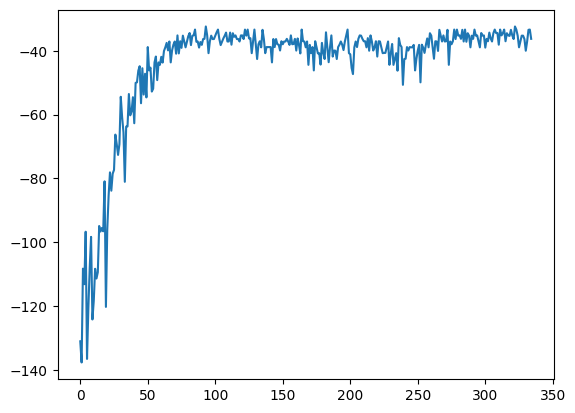

In [ ]:
import matplotlib.pyplot as plt
targ_env = env._get_target_envs(indices=[0])[0]
plt.plot(targ_env.get_statistics()['global_rewards'])
plt.show()

4 12


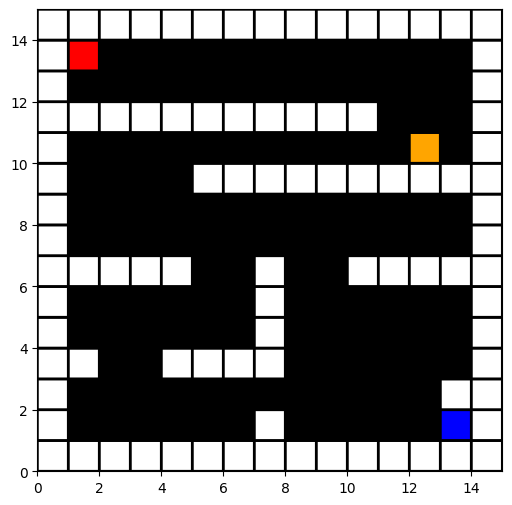

In [ ]:
obs = env.reset()
iterations = 100
for i in range(0, iterations):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    targ_env = env._get_target_envs(indices=[0])[0]
    targ_env.render()
    #env.render()

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(
    model,
    env,
    n_eval_episodes=10,
    deterministic=True,
)


In [ ]:
env.show_space(global_map=True)